# GDSCv2 Analysis

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns
from sklearn.decomposition import PCA

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple, get_model_bhm, get_model_bhm_nc, get_model_logres, get_model_logres_nc
from pyBasket.clustering import get_cluster_df_by_basket, get_cluster_df_by_cluster, plot_PCA

# Load expression data

In [5]:
data_dir = os.path.abspath(os.path.join('..', 'Data'))
data_dir

'/Users/joewandy/Work/git/pyBasket/Data'

The data consists of 446 samples x 19957 transcripts

In [6]:
expr_file = os.path.join(data_dir, 'GDSCv2.exprsALL.tsv')
df = pd.read_csv(expr_file, sep='\t')
expr_df = df.drop(df.index[-25:]).transpose()
expr_df

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
KMH-2,2.644470,-9.965784,7.369643,2.521319,4.211213,-9.965784,1.926462,5.212597,3.104173,3.763338,...,-6.705062,-9.965784,-1.975997,-9.965784,2.052412,-9.965784,-0.561202,-0.021777,-2.262192,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


Each sample is assigned to one tissue

In [7]:
tissue_df = df.tail(25).astype(int).transpose()
tissue_df

,CNS/Brain,Bone,Prostate,Esophagus/Stomach,Bladder/Urinary Tract,Ovary/Fallopian Tube,Lymphoid,Kidney,Thyroid,Soft Tissue,...,Uterus,Pancreas,Breast,Cervix,Bowel,Peripheral Nervous System,Liver,Biliary Tract,Other,Ampulla of Vater
TGBC24TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
EGI-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TGBC1TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ETK-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
SW1710,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
KMH-2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
HTC-C3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
IHH-4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
flat_list = tissue_df.reset_index().melt(id_vars='index', var_name='tissue', value_name='belongs_to_tissue')
flat_list = flat_list[flat_list['belongs_to_tissue'] != 0]

# set the index to the sample name
flat_list = flat_list.set_index('index')

# create the dictionary
sample_dict = flat_list['tissue'].to_dict()

In [9]:
tissues = np.array([sample_dict[s] for s in expr_df.index.values])
tissues[0:10]

array(['Biliary Tract', 'Biliary Tract', 'Biliary Tract', 'Biliary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bone'], dtype='<U25')

# Do PCA and colour by basket (tissues)

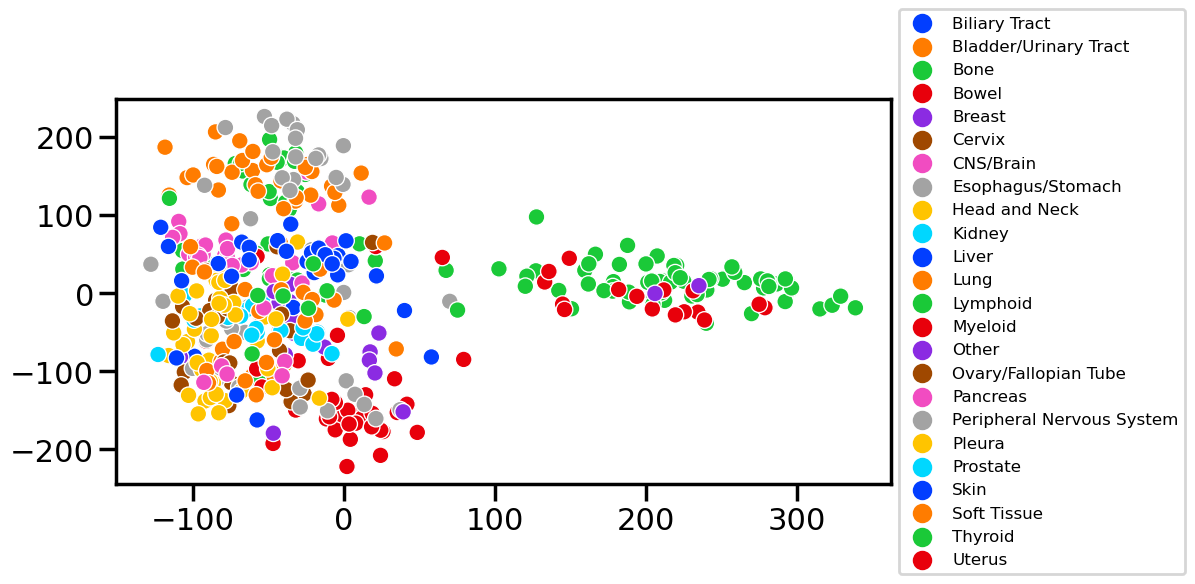

PCA explained variance [0.12949628 0.22238095 0.28729125 0.32075101 0.34293046 0.36347672
 0.38132787 0.39535598 0.40877655 0.42098275]


In [10]:
_ = plot_PCA(expr_df, n_components=10, hue=tissues)

# Load drug responses data

Each sample also has its corresponding drug response. There are 11 drugs.
Not sure why there are 1104 samples?

In [11]:
response_file = os.path.join(data_dir, 'GDSCv2.aacALL.tsv')
response_df = pd.read_csv(response_file, sep='\t').transpose()
response_df

,Bortezomib,Entinostat,Sirolimus,Docetaxel,Gemcitabine,Crizotinib,Lapatinib,Vorinostat,Erlotinib,Paclitaxel,Pictilisib
143B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22Rv1,0.184836,0.142503,0.304184,0.111977,0.596289,0.077036,0.048663,0.240865,0.069736,0.015539,0.254125
23132/87,0.228235,0.121580,0.208475,0.232821,0.407328,0.018921,0.172438,0.235145,0.124366,0.025982,0.431203
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
YH-13,0.174638,0.019992,0.157624,0.211467,0.359880,0.008977,0.069979,0.144077,0.108331,0.087400,0.349741
YKG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YMB-1-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YT,0.230123,NaN,0.212004,0.113564,0.666782,NaN,0.084477,0.235547,0.000000,0.000000,0.172903


In [12]:
response_df.loc['TGBC24TKB']

Bortezomib     0.046804
Entinostat     0.074151
Sirolimus      0.015096
Docetaxel      0.229496
Gemcitabine    0.410541
Crizotinib     0.000000
Lapatinib      0.239909
Vorinostat     0.181613
Erlotinib      0.128392
Paclitaxel     0.014104
Pictilisib     0.387379
Name: TGBC24TKB, dtype: float64

## Collect the samples and responses for the drug

In [13]:
drug_name = 'Erlotinib'

In [14]:
samples = tissue_df.index.values
response_dict = response_df[drug_name].to_dict()
responses = np.array([response_dict[s] for s in samples])
len(samples), len(responses), len(tissues)

(446, 446, 446)

In [15]:
df = pd.DataFrame({
    'tissues': tissues,
    'samples': samples,    
    'responses': responses
})
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
441,Thyroid,ASH-3,0.082204
442,Thyroid,KMH-2,NaN
443,Thyroid,HTC-C3,0.078680
444,Thyroid,IHH-4,0.020141


## Drop all the NaN responses

In [16]:
df = df.dropna(subset=['responses'])
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
440,Thyroid,WRO,0.018343
441,Thyroid,ASH-3,0.082204
443,Thyroid,HTC-C3,0.078680
444,Thyroid,IHH-4,0.020141


In [17]:
df['tissues'].unique()

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [18]:
df.groupby('tissues').count()

,samples,responses
tissues,,
Biliary Tract,4,4
Bladder/Urinary Tract,5,5
Bone,25,25
Bowel,28,28
Breast,10,10
CNS/Brain,14,14
Cervix,13,13
Esophagus/Stomach,19,19
Head and Neck,16,16


In [19]:
df['responses'].max(), df['responses'].min()

(0.352487709036072, 0.0)

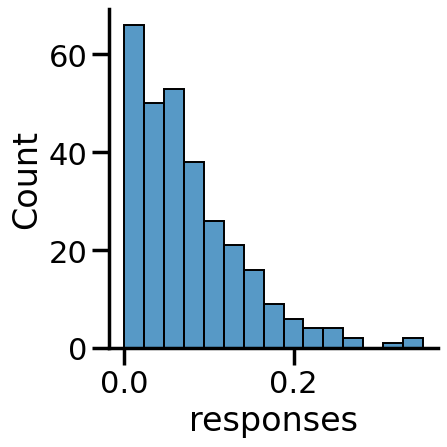

In [20]:
sns.displot(df['responses'])

In [21]:
df['responses'].mean(), df['responses'].median()

(0.07533823628570624, 0.06098308922444)

# Select a few baskets for analysis

In [22]:
# basket_names = [
#     'Lymphoid',
#     'Bowel',
#     'Bone',
#     'Lung',
#     'Esophagus/Stomach'
# ]

In [23]:
basket_names = df['tissues'].unique()
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [24]:
df_filtered = df[df['tissues'].isin(basket_names)].reset_index(drop=True)
df_filtered

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
293,Thyroid,WRO,0.018343
294,Thyroid,ASH-3,0.082204
295,Thyroid,HTC-C3,0.078680
296,Thyroid,IHH-4,0.020141


In [25]:
sample_list = df_filtered['samples'].tolist()
expr_df_filtered = expr_df[expr_df.index.isin(sample_list)]
expr_df_filtered.shape, expr_df.shape

((298, 19957), (446, 19957))

## Do PCA again on these samples

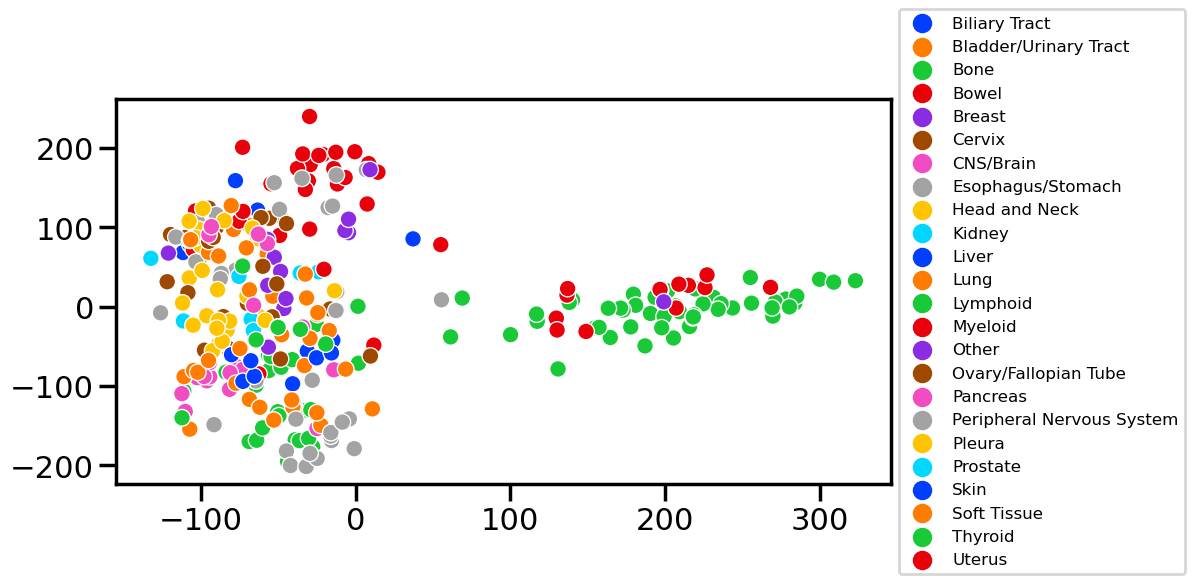

PCA explained variance [0.13829637 0.22985784 0.29027512 0.32311007 0.34617996 0.36607902
 0.38141876 0.39592629 0.40932319 0.4213392 ]


In [26]:
pc1, pc2 = plot_PCA(expr_df_filtered, n_components=10, hue=df_filtered['tissues'].values)

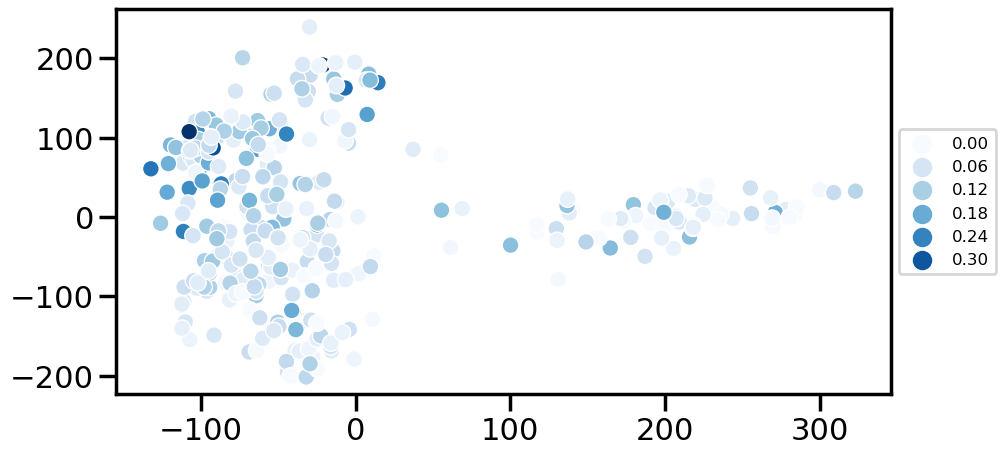

In [27]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

# Try clustering

In [28]:
expr_df_filtered.shape

(298, 19957)

In [29]:
classes = df_filtered.set_index('samples')
classes

,tissues,responses
samples,,
TGBC24TKB,Biliary Tract,0.128392
EGI-1,Biliary Tract,0.057719
TGBC1TKB,Biliary Tract,0.051036
ETK-1,Biliary Tract,0.096227
SW1710,Bladder/Urinary Tract,0.071891
...,...,...
WRO,Thyroid,0.018343
ASH-3,Thyroid,0.082204
HTC-C3,Thyroid,0.078680


In [30]:
C = 10

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=C, random_state=42)
kmeans.fit(expr_df_filtered)

cluster_labels = kmeans.labels_
# df['cluster'] = cluster_labels

cluster_labels

array([8, 0, 0, 0, 2, 0, 9, 0, 0, 9, 7, 7, 9, 7, 7, 7, 7, 7, 9, 7, 7, 2,
       9, 7, 2, 9, 7, 9, 7, 7, 9, 7, 7, 9, 8, 8, 8, 6, 0, 8, 8, 8, 0, 8,
       8, 8, 8, 0, 2, 8, 8, 8, 9, 2, 8, 8, 0, 8, 8, 8, 8, 8, 6, 6, 6, 6,
       6, 6, 6, 0, 0, 6, 0, 0, 0, 0, 4, 0, 2, 2, 0, 0, 2, 2, 0, 9, 2, 9,
       7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 8, 0, 0, 0, 2, 8, 8, 0, 0, 8,
       8, 0, 0, 8, 0, 2, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 9, 2, 2, 2, 2, 2, 2, 8, 2, 4, 6, 4, 0, 4, 0, 4, 4, 4, 2, 4, 0,
       0, 4, 0, 2, 4, 4, 4, 6, 4, 4, 8, 1, 1, 3, 5, 3, 5, 5, 5, 5, 1, 1,
       3, 5, 1, 1, 1, 1, 3, 1, 1, 1, 5, 1, 5, 1, 5, 1, 5, 5, 1, 5, 3, 1,
       5, 5, 5, 3, 5, 5, 5, 3, 3, 3, 1, 5, 5, 3, 2, 1, 5, 5, 5, 5, 3, 3,
       3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 9, 8, 5, 6, 0, 2, 2, 0, 2, 2, 0, 9,
       0, 0, 2, 0, 2, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 2,
       2, 2, 2, 2, 9, 2, 2, 0, 2, 0, 2, 9, 2, 9, 9, 9, 9, 2, 2, 2, 9, 9,
       9, 9, 9, 9, 2, 9, 9, 2, 9, 0, 2, 2], dtype=i

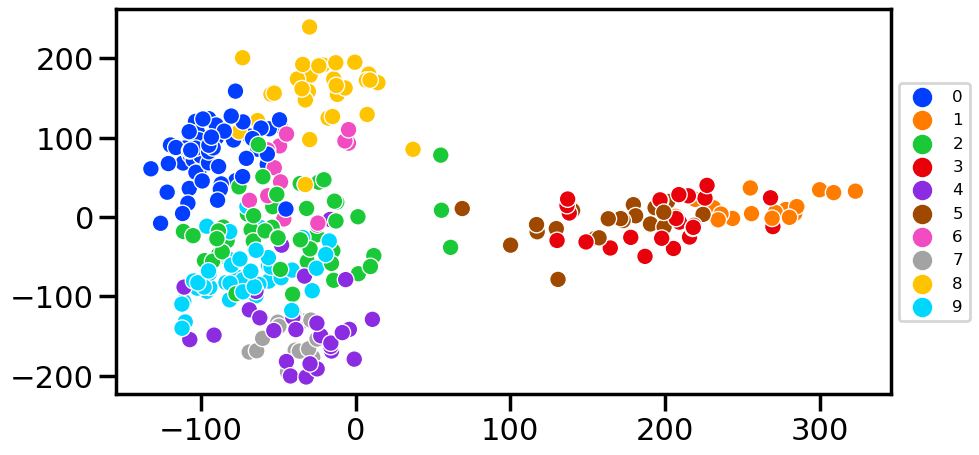

PCA explained variance [0.13829637 0.22985784 0.29027512 0.32311007 0.34617996 0.36607902
 0.38141876 0.39592672 0.40932358 0.42133659]


In [32]:
_ = plot_PCA(expr_df_filtered, n_components=10, hue=cluster_labels)

# Run basket trial analysis

In [33]:
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [34]:
K = len(basket_names)
K, C

(24, 10)

Create clustering dataframe

In [35]:
class_labels = classes.tissues.values
len(class_labels), len(cluster_labels)

(298, 298)

In [36]:
cluster_df = get_cluster_df_by_basket(class_labels, cluster_labels)
cluster_df

,sk_0,sk_1,sk_2,sk_3,sk_4,sk_5,sk_6,sk_7,sk_8,sk_9
Biliary Tract,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
Bladder/Urinary Tract,0.600000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
Bone,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.320000
Bowel,0.142857,0.000000,0.071429,0.000000,0.000000,0.000000,0.035714,0.000000,0.714286,0.035714
Breast,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000
CNS/Brain,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.857143
Cervix,0.615385,0.000000,0.307692,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000
Esophagus/Stomach,0.526316,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.315789,0.000000
Head and Neck,0.750000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187500
Kidney,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot: >

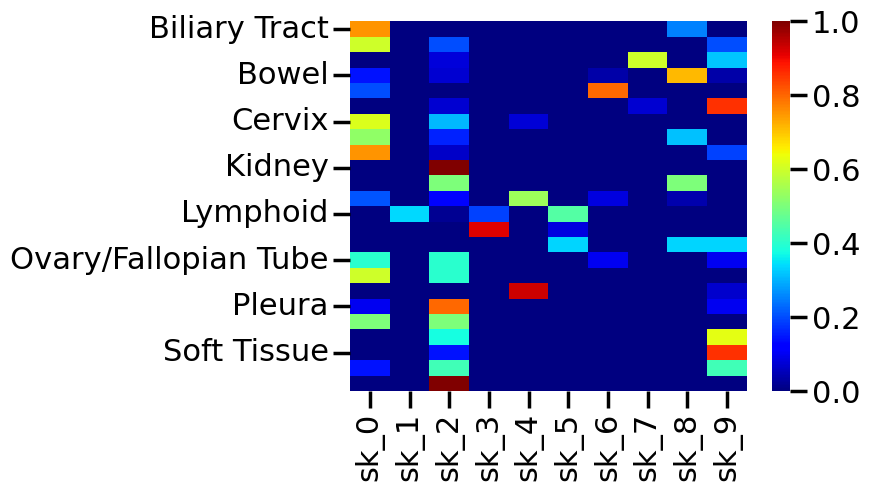

In [37]:
sns.heatmap(cluster_df, cmap='jet')

## Add the counts of responsive patients for each basket

In [38]:
n_trial_df = df_filtered.groupby('tissues').count().drop(columns=['responses'])
n_trial_df.rename(columns={'samples': 'n_trial'}, inplace=True)

In [39]:
aac_thresh = df['responses'].median()

n_success_df = df_filtered[df_filtered['responses'] < aac_thresh].groupby('tissues').count().drop(columns=['responses'])
n_success_df.rename(columns={'samples': 'n_success'}, inplace=True)

In [40]:
data_df = pd.concat([cluster_df, n_success_df, n_trial_df], axis=1)
data_df

,sk_0,sk_1,sk_2,sk_3,sk_4,sk_5,sk_6,sk_7,sk_8,sk_9,n_success,n_trial
Biliary Tract,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,2.0,4
Bladder/Urinary Tract,0.600000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,3.0,5
Bone,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.320000,13.0,25
Bowel,0.142857,0.000000,0.071429,0.000000,0.000000,0.000000,0.035714,0.000000,0.714286,0.035714,11.0,28
Breast,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,4.0,10
CNS/Brain,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.857143,9.0,14
Cervix,0.615385,0.000000,0.307692,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,13
Esophagus/Stomach,0.526316,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.315789,0.000000,7.0,19
Head and Neck,0.750000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187500,NaN,16
Kidney,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,5


In [41]:
data_df = data_df.fillna(0)

In [42]:
n_burn_in = int(1E3)
n_sample = int(1E3)
target_accept = 0.99

## Run simple model

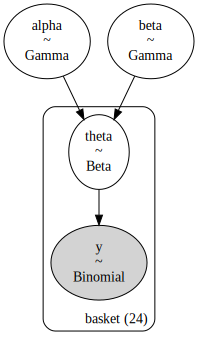

In [43]:
model_simple = get_model_simple(data_df)
pm.model_to_graphviz(model_simple)

In [44]:
with model_simple:
    trace_simple = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


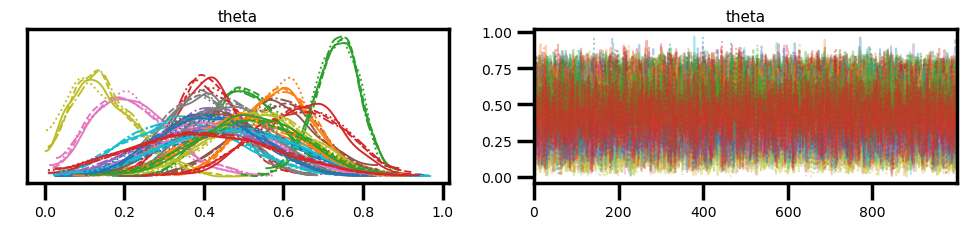

In [45]:
az.plot_trace(trace_simple, var_names=['theta']);

In [46]:
stacked_simple = az.extract(trace_simple)

array([0.47272305, 0.51421883, 0.50461107, 0.4079883 , 0.42430912,
       0.57970652, 0.21868854, 0.39439978, 0.15001186, 0.35623506,
       0.4642636 , 0.58517419, 0.73365588, 0.63739007, 0.42357839,
       0.42631372, 0.43552888, 0.46267001, 0.53867121, 0.46763736,
       0.41465535, 0.51148353, 0.51568884, 0.4041458 ])

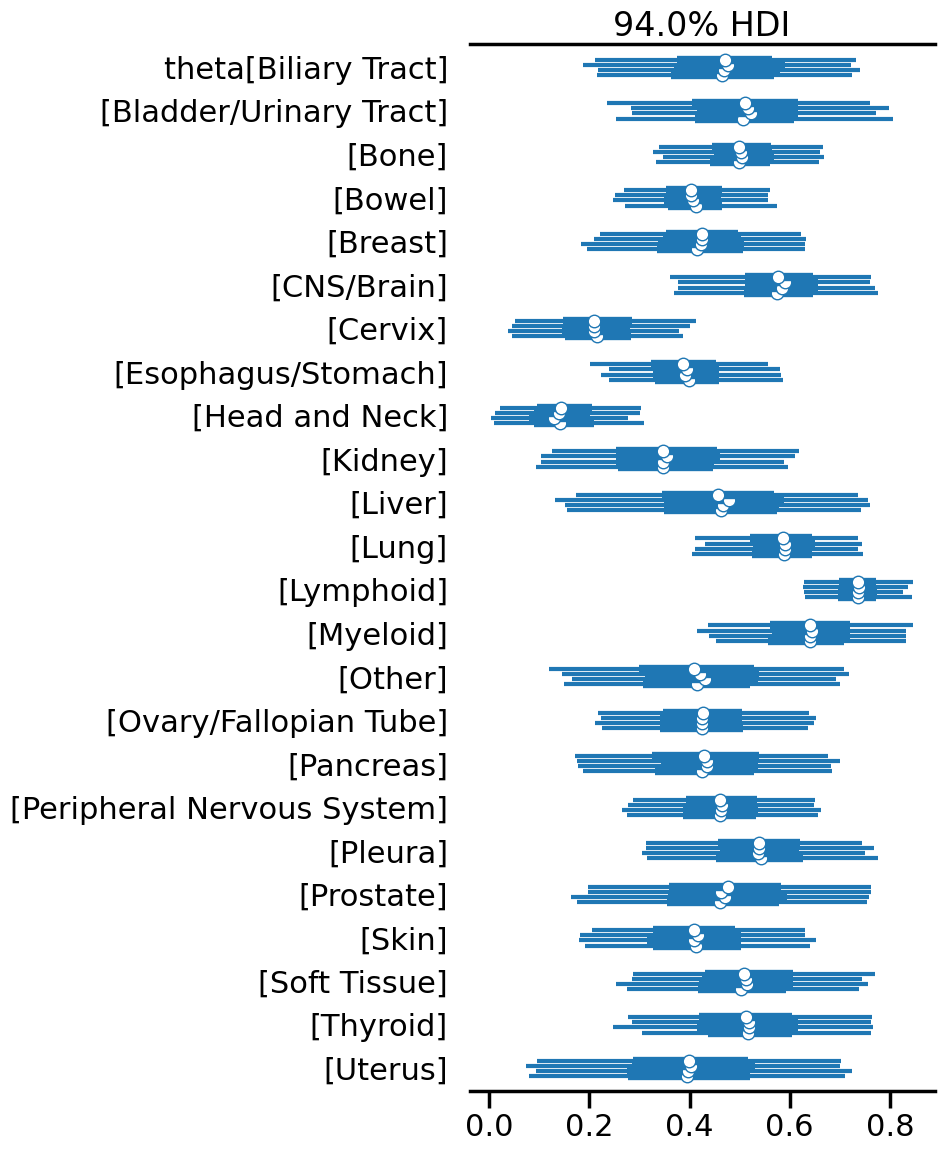

In [47]:
az.plot_forest(trace_simple, var_names='theta')

predicted = np.mean(stacked_simple.theta.values, axis=1)
predicted

## Run BHM

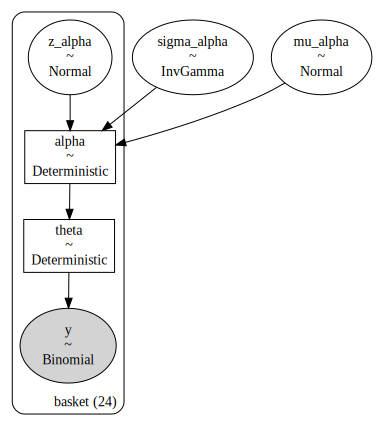

In [48]:
model_bhm_nc = get_model_bhm_nc(data_df)
pm.model_to_graphviz(model_bhm_nc)

In [49]:
with model_bhm_nc:
    trace_bhm_nc = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, mu_alpha, sigma_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


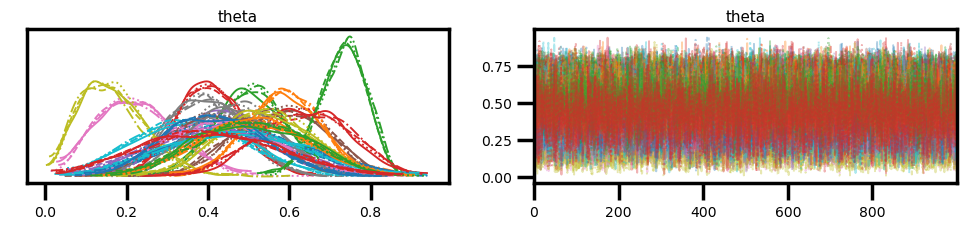

In [50]:
az.plot_trace(trace_bhm_nc, var_names=['theta']);

In [51]:
stacked_bhm_nc = az.extract(trace_bhm_nc)

array([-0.12053684,  0.07092821,  0.0186672 , -0.39332578, -0.31843594,
        0.33925284, -1.31990777, -0.44933882, -1.74594677, -0.6452325 ,
       -0.13809823,  0.35346869,  1.02163481,  0.59528069, -0.33995222,
       -0.32174699, -0.29142389, -0.14774272,  0.17199049, -0.14289726,
       -0.3590129 ,  0.05402794,  0.04319036, -0.43710172])

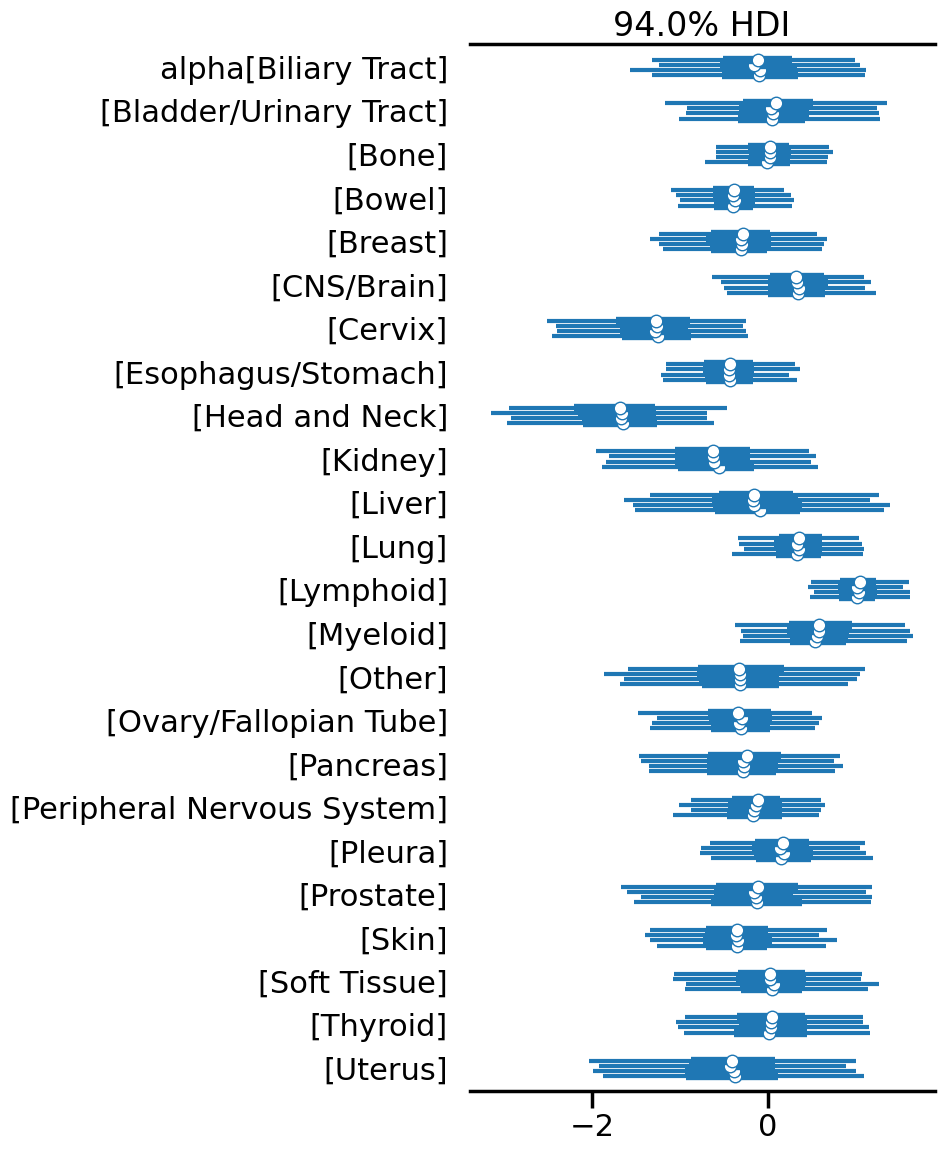

In [52]:
az.plot_forest(trace_bhm_nc, var_names='alpha')

predicted = np.mean(stacked_bhm_nc.alpha.values, axis=1)
predicted

array([0.47279695, 0.51611611, 0.50454434, 0.40554511, 0.42574144,
       0.5797559 , 0.22689851, 0.39365952, 0.16649324, 0.35756939,
       0.46951865, 0.58457133, 0.7312765 , 0.63603713, 0.42494758,
       0.4251679 , 0.43344393, 0.46473117, 0.540288  , 0.46823365,
       0.41697618, 0.51211719, 0.50990729, 0.40656213])

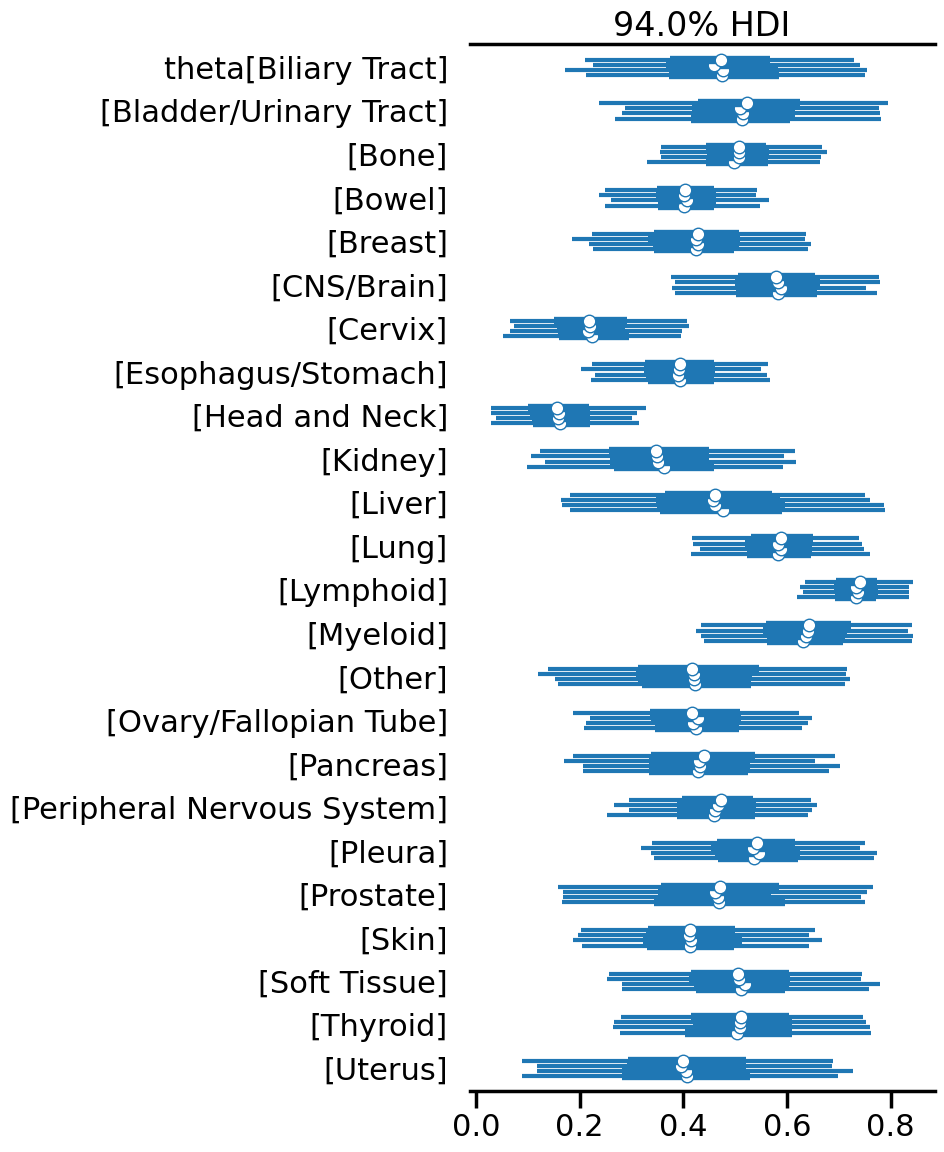

In [53]:
az.plot_forest(trace_bhm_nc, var_names='theta')

predicted = np.mean(stacked_bhm_nc.theta.values, axis=1)
predicted

## Run logistic regression

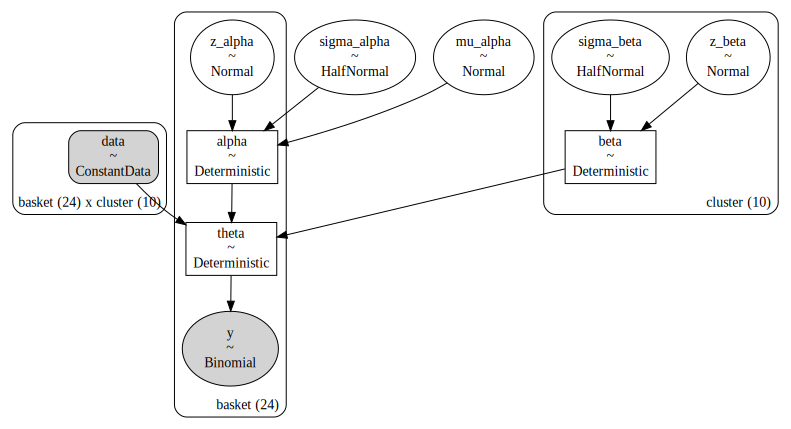

In [54]:
model_logres_nc = get_model_logres_nc(data_df)
pm.model_to_graphviz(model_logres_nc)

In [55]:
with model_logres_nc:
    trace_logres_nc = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, z_beta, mu_alpha, sigma_alpha, sigma_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


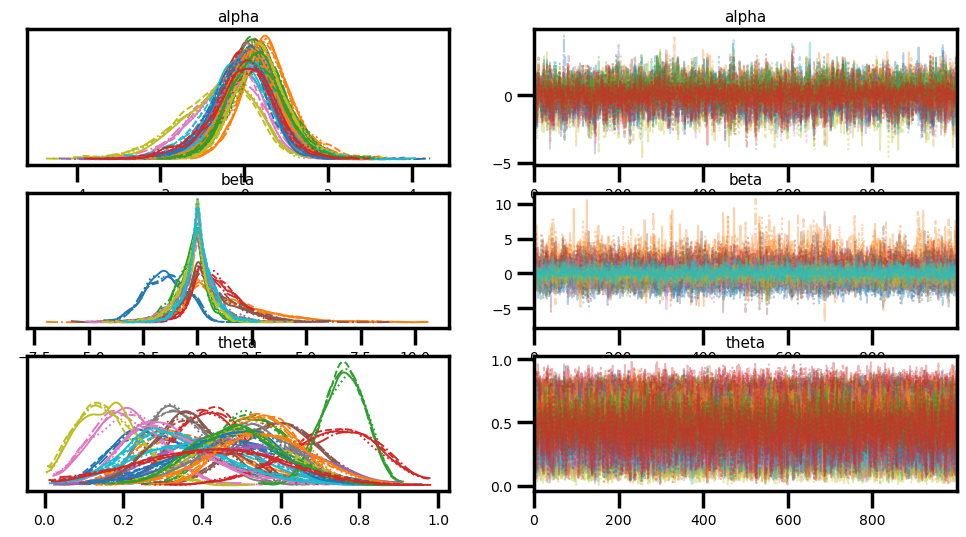

In [56]:
az.plot_trace(trace_logres_nc, var_names=['alpha', 'beta', 'theta']);

In [57]:
stacked_logres_nc = az.extract(trace_logres_nc)

array([ 0.3231972 ,  0.43056653,  0.08946004, -0.00752551,  0.04151324,
        0.31301481, -0.41396448,  0.19052609, -0.670466  , -0.18263057,
        0.12944182,  0.51940874,  0.38013387,  0.22884386, -0.08439931,
        0.18343076,  0.20977094, -0.03766755,  0.40336607,  0.20039219,
       -0.08603051,  0.1715071 ,  0.27831792, -0.04585223])

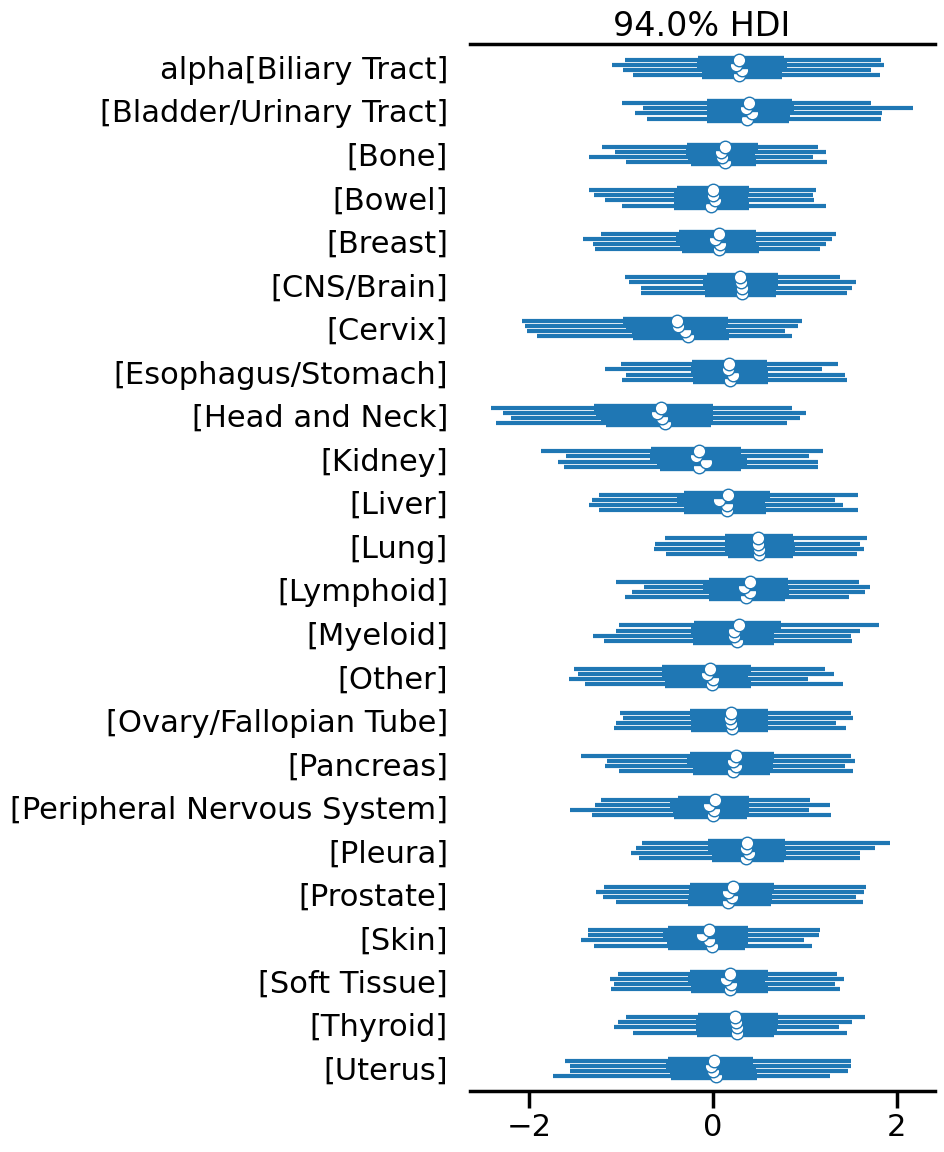

In [58]:
az.plot_forest(trace_logres_nc, var_names='alpha')

predicted = np.mean(stacked_logres_nc.alpha.values, axis=1)
predicted

array([-1.46697546,  1.14794573, -0.32887158,  0.83935744,  0.10063351,
        0.55521485, -0.09774911,  0.01365962, -0.15514675,  0.10368298])

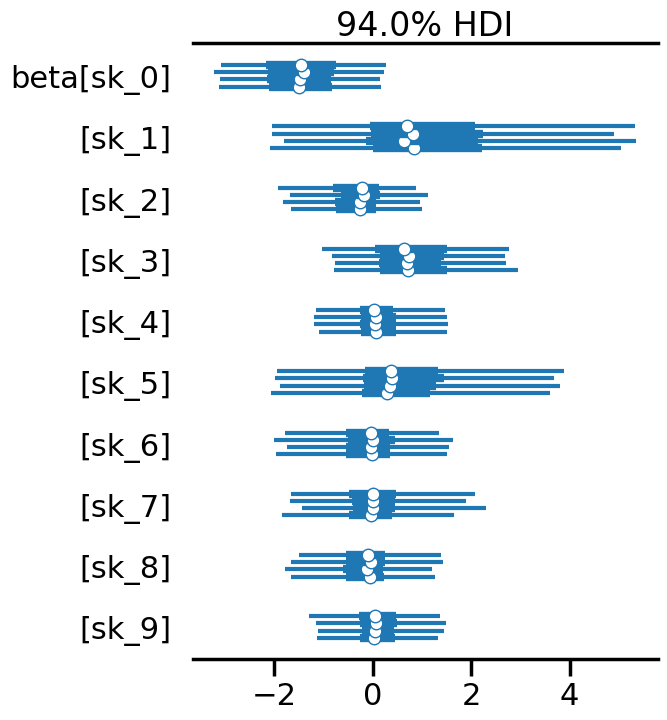

In [59]:
az.plot_forest(trace_logres_nc, var_names='beta')

predicted = np.mean(stacked_logres_nc.beta.values, axis=1)
predicted

array([0.32103876, 0.38684841, 0.52521794, 0.41570002, 0.424852  ,
       0.58940683, 0.21102663, 0.3408941 , 0.16406992, 0.38858655,
       0.47463739, 0.55093827, 0.75922962, 0.72284703, 0.52074976,
       0.37519839, 0.32101766, 0.51505127, 0.50063181, 0.34443103,
       0.46704862, 0.54954303, 0.49293397, 0.42264927])

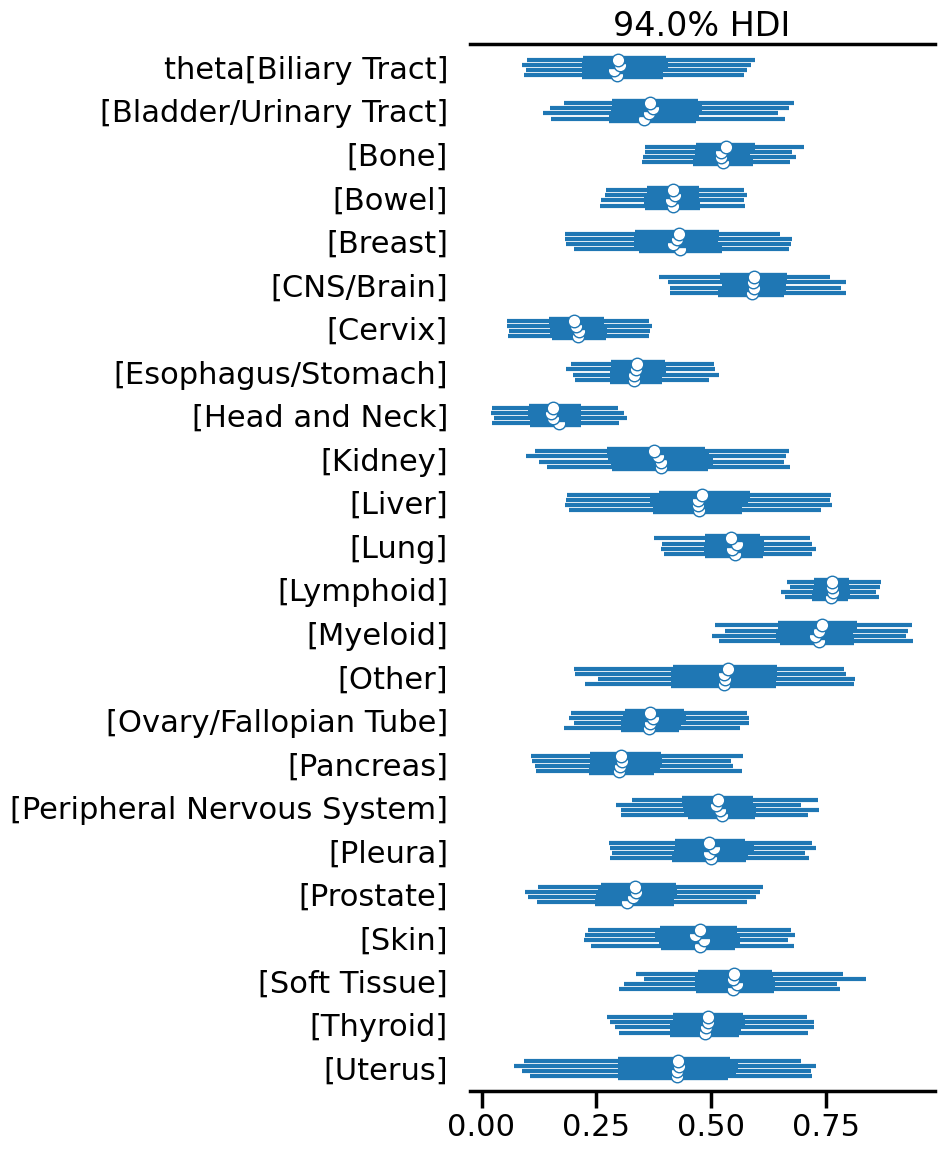

In [60]:
az.plot_forest(trace_logres_nc, var_names='theta')

predicted = np.mean(stacked_logres_nc.theta.values, axis=1)
predicted

# Check model fit

In [61]:
loo_simple = az.loo(trace_simple)
loo_simple

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -49.56     4.59
p_loo       12.21        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5   20.8%
 (0.5, 0.7]   (ok)         12   50.0%
   (0.7, 1]   (bad)         6   25.0%
   (1, Inf)   (very bad)    1    4.2%

In [62]:
loo_bhm_nc = az.loo(trace_bhm_nc)
loo_bhm_nc

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -50.63     5.28
p_loo       12.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5   20.8%
 (0.5, 0.7]   (ok)         10   41.7%
   (0.7, 1]   (bad)         8   33.3%
   (1, Inf)   (very bad)    1    4.2%

In [63]:
loo_logres_nc = az.loo(trace_logres_nc)
loo_logres_nc

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -50.46     4.25
p_loo       11.85        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8   33.3%
 (0.5, 0.7]   (ok)          8   33.3%
   (0.7, 1]   (bad)         8   33.3%
   (1, Inf)   (very bad)    0    0.0%

In [64]:
ic = 'loo'
df_comp_loo = az.compare({
    'simple': trace_simple, 
    'bhm': trace_bhm_nc,
    'logres': loo_logres_nc,
}, ic=ic)
df_comp_loo

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
simple,0,-49.564633,12.211443,0.000000,0.884327,4.594653,0.000000,True,log
logres,1,-50.463840,11.850502,0.899207,0.115673,4.247274,1.523285,True,log
bhm,2,-50.634963,12.885364,1.070330,0.000000,5.275884,0.992100,True,log


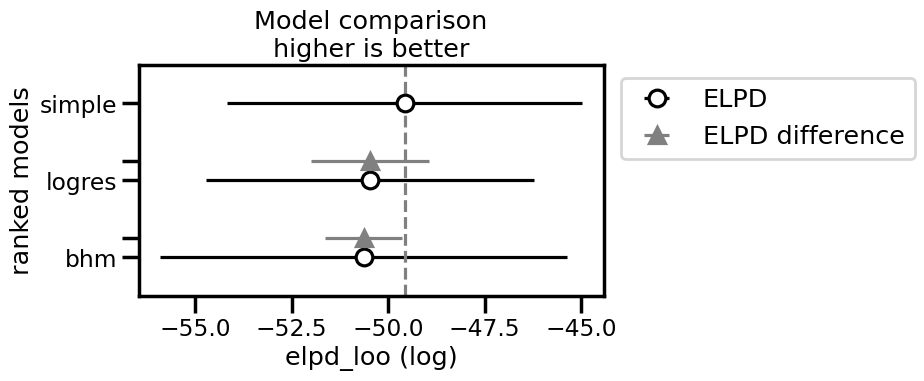

In [65]:
az.plot_compare(df_comp_loo);

# Any interesting data to look at?

## Which baskets have the highest / lowest response rates?

In [67]:
theta_pred = np.mean(stacked_logres_nc.theta.values, axis=1)
idx = np.argsort(theta_pred)

sorted_theta_pred = theta_pred[idx]
sorted_basket_names = basket_names[idx]
sorted_theta_pred, sorted_basket_names

(array([0.16406992, 0.21102663, 0.32101766, 0.32103876, 0.3408941 ,
        0.34443103, 0.37519839, 0.38684841, 0.38858655, 0.41570002,
        0.42264927, 0.424852  , 0.46704862, 0.47463739, 0.49293397,
        0.50063181, 0.51505127, 0.52074976, 0.52521794, 0.54954303,
        0.55093827, 0.58940683, 0.72284703, 0.75922962]),
 array(['Head and Neck', 'CNS/Brain', 'Pancreas', 'Biliary Tract',
        'Esophagus/Stomach', 'Prostate', 'Ovary/Fallopian Tube',
        'Bladder/Urinary Tract', 'Kidney', 'Bowel', 'Uterus', 'Breast',
        'Skin', 'Liver', 'Thyroid', 'Pleura', 'Peripheral Nervous System',
        'Other', 'Bone', 'Soft Tissue', 'Lung', 'Cervix', 'Myeloid',
        'Lymphoid'], dtype=object))

## Pick top few baskets having the highest and lowest response rates

In [68]:
pick = 5
selected_names = list(sorted_basket_names[0:pick]) + list(sorted_basket_names[-pick:])
selected_theta = list(sorted_theta_pred[0:pick]) + list(sorted_theta_pred[-pick:])
selected_names, selected_theta
selected_df = pd.DataFrame({
    'tissue': selected_names,
    'theta': selected_theta
}).set_index('tissue')
selected_df

,theta
tissue,
Head and Neck,0.164070
CNS/Brain,0.211027
Pancreas,0.321018
Biliary Tract,0.321039
Esophagus/Stomach,0.340894
Soft Tissue,0.549543
Lung,0.550938
Cervix,0.589407
Myeloid,0.722847


## Create a dataframe for all the relevant info

In [69]:
selected_df = selected_df.join(data_df, how='left')
selected_df

,theta,sk_0,sk_1,sk_2,sk_3,sk_4,sk_5,sk_6,sk_7,sk_8,sk_9,n_success,n_trial
tissue,,,,,,,,,,,,,
Head and Neck,0.164070,0.750000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187500,0.0,16
CNS/Brain,0.211027,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.857143,9.0,14
Pancreas,0.321018,0.600000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,5
Biliary Tract,0.321039,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,2.0,4
Esophagus/Stomach,0.340894,0.526316,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.315789,0.000000,7.0,19
Soft Tissue,0.549543,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.857143,4.0,7
Lung,0.550938,0.208333,0.000000,0.125000,0.000000,0.541667,0.000000,0.083333,0.000000,0.041667,0.000000,15.0,24
Cervix,0.589407,0.615385,0.000000,0.307692,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,13
Myeloid,0.722847,0.000000,0.000000,0.000000,0.916667,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,9.0,12


## Plot their partitions again

<AxesSubplot: ylabel='tissue'>

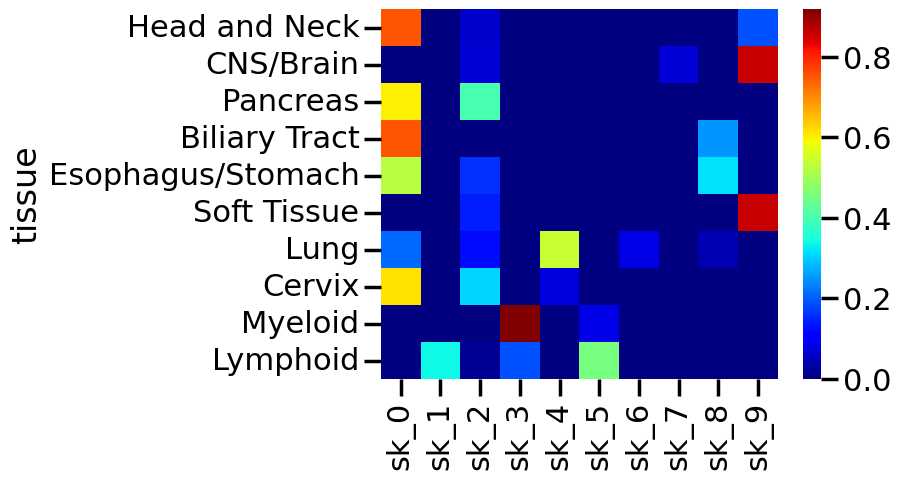

In [70]:
sns.heatmap(selected_df.iloc[:, 1:11], cmap='jet')

## Plot inferred cluster coefficients

<AxesSubplot: xlabel='cluster', ylabel='weight'>

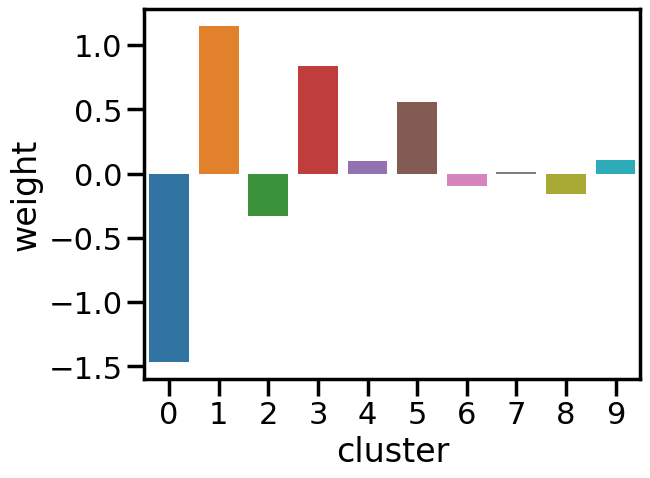

In [71]:
beta_pred = np.mean(stacked_logres_nc.beta.values, axis=1)
plot_df = pd.DataFrame({
    'cluster': [i for i in range(C)],
    'weight': beta_pred
    
})
sns.barplot(plot_df, x='cluster', y='weight')

## Check Cluster 0

In [82]:
query_cluster_idx = 0
query_cluster = 'sk_%d' % query_cluster_idx
query_tissues = data_df[(data_df[query_cluster] > 0)].index.values
query_cluster, query_tissues

('sk_0',
 array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bowel', 'Breast',
        'Cervix', 'Esophagus/Stomach', 'Head and Neck', 'Lung',
        'Ovary/Fallopian Tube', 'Pancreas', 'Pleura', 'Prostate',
        'Thyroid'], dtype=object))

In [83]:
expr_df_filtered.shape, df_filtered.shape, class_labels.shape, cluster_labels.shape

((298, 19957), (298, 3), (298,), (298,))

In [84]:
query_idx = np.isin(class_labels, query_tissues)

query_expr = expr_df_filtered[query_idx]
query_df = df_filtered[query_idx]
query_class_labels = class_labels[query_idx]
query_cluster_labels = cluster_labels[query_idx]

query_df.shape, query_expr.shape, query_class_labels.shape, query_cluster_labels.shape

((153, 3), (153, 19957), (153,), (153,))

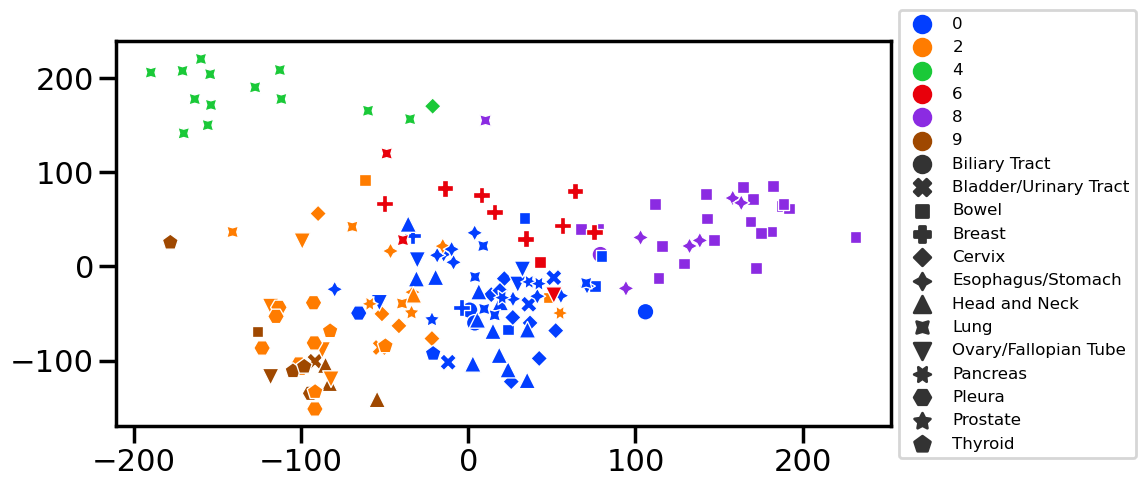

PCA explained variance [0.10617243 0.19184819 0.25375884 0.28647921 0.31117854 0.33289959
 0.35134099 0.3686277  0.38471826 0.39887923]


In [85]:
pc1, pc2 = plot_PCA(query_expr, n_components=10, hue=query_cluster_labels, style=query_class_labels)

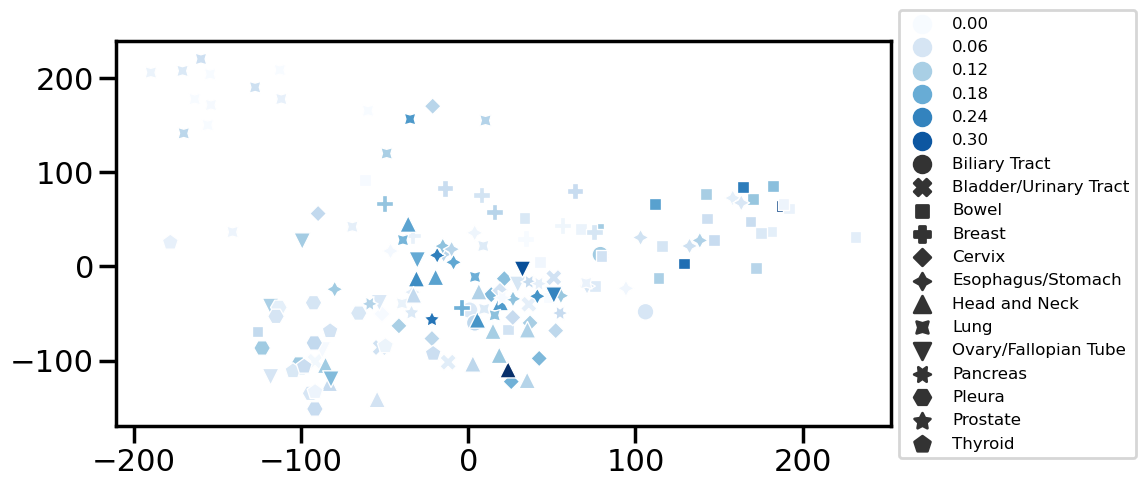

In [86]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=query_df['responses'].values, style=query_class_labels, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

## Check Cluster 1

Retrieve all selected tissues that also occur in cluster 1

In [87]:
query_cluster_idx = 1
query_cluster = 'sk_%d' % query_cluster_idx
query_tissues = data_df[(data_df[query_cluster] > 0)].index.values
query_cluster, query_tissues

('sk_1', array(['Lymphoid'], dtype=object))

In [88]:
expr_df_filtered.shape, df_filtered.shape, class_labels.shape, cluster_labels.shape

((298, 19957), (298, 3), (298,), (298,))

In [89]:
query_idx = np.isin(class_labels, query_tissues)

query_expr = expr_df_filtered[query_idx]
query_df = df_filtered[query_idx]
query_class_labels = class_labels[query_idx]
query_cluster_labels = cluster_labels[query_idx]

query_df.shape, query_expr.shape, query_class_labels.shape, query_cluster_labels.shape

((53, 3), (53, 19957), (53,), (53,))

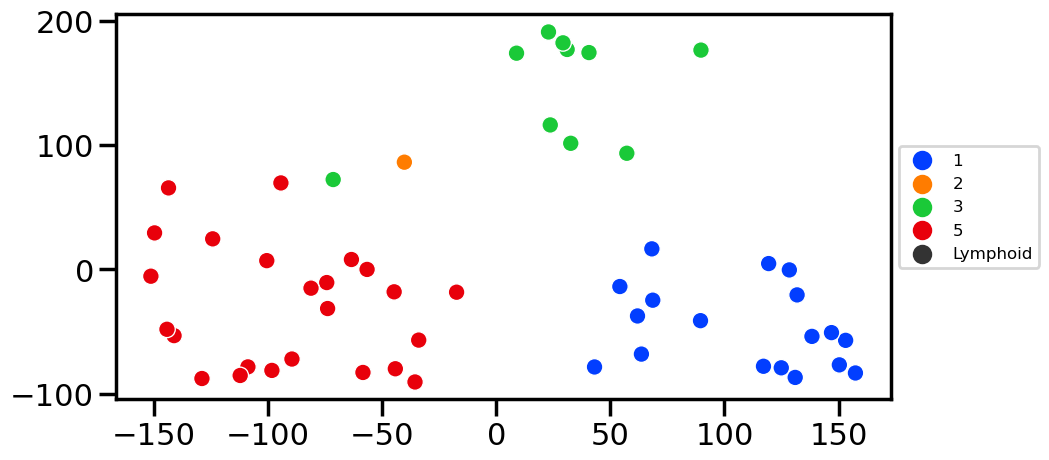

PCA explained variance [0.12555606 0.21963416 0.27718524 0.33086428 0.37136483 0.40532091
 0.43432588 0.45996151 0.48395775 0.50688394]


In [90]:
pc1, pc2 = plot_PCA(query_expr, n_components=10, hue=query_cluster_labels, style=query_class_labels)

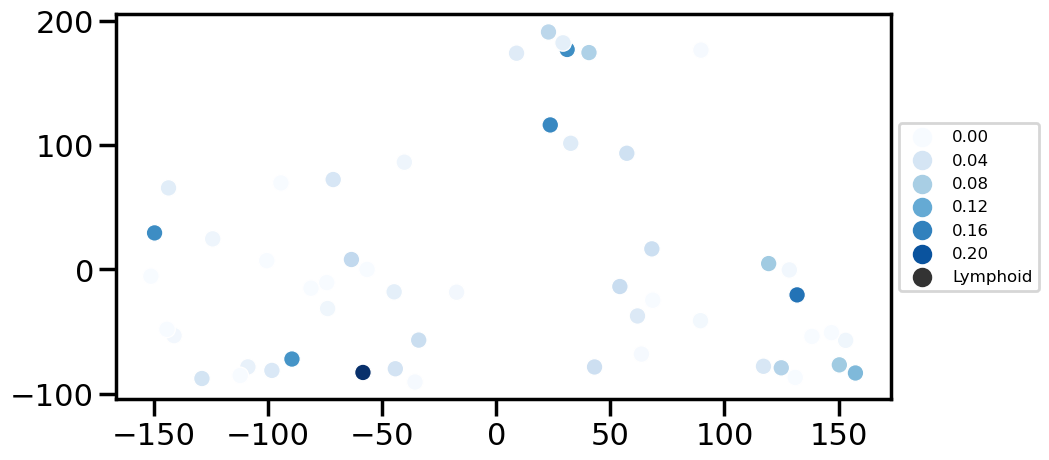

In [91]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=query_df['responses'].values, style=query_class_labels, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)